In [2]:
import pandas as pd
from boruta import BorutaPy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [3]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [4]:
#remove missing values
X=X.copy()
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [5]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.6,random_state=42)
x_dev,x_test,y_dev,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

#train 0.6
#dev 0.2
#test 0.2
#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_dev=scaler_x.transform(x_dev)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_dev=scaler_y.transform(y_dev.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))


### Tests

In [6]:
#fitting model

model_nn = MLPRegressor(hidden_layer_sizes=(2),
                        max_iter=10000,
                        random_state=42,)

#fit
model_nn.fit(x_train,y_train.ravel())

#get predictions
test_pred=model_nn.predict(x_test)
dev_pred=model_nn.predict(x_dev)
train_pred=model_nn.predict(x_train)

test_mse = mean_squared_error(y_test, test_pred)
dev_mse=mean_squared_error(y_dev,dev_pred)
train_mse=mean_squared_error(y_train,train_pred)

print('train mse: ' +str(train_mse)+'\n'+'dev mse: ' +str(dev_mse)+'\n'+'test mse: '+str(test_mse))


train mse: 0.25395925573409456
dev mse: 0.35007942702723743
test mse: 0.41107304982878795


Text(0.5, 1.0, "Before 'boruta'")

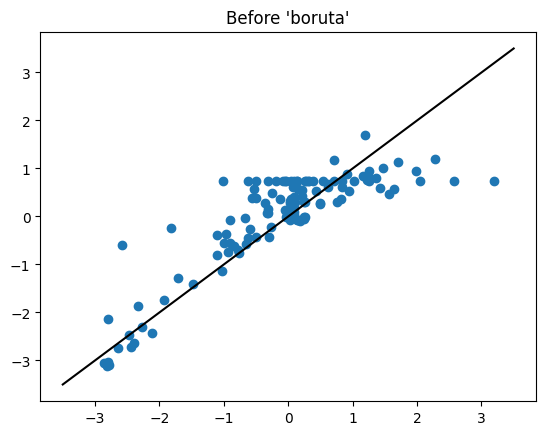

In [7]:
#parity on test set
plt.scatter(y_test, test_pred)
plt.plot([-3.5,3.5],[-3.5,3.5],'black')
plt.title('Before \'boruta\'')

### Importance evaluation

In [8]:
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]
importance_df=pd.DataFrame()
index_of_imp={}

for structure in layers:
    
    # Train MLPRegressor
    mlp = MLPRegressor(hidden_layer_sizes=structure,
                        max_iter=10000,
                        random_state=42,)

    mlp.fit(x_train, y_train.ravel())

    # Perform permutation importance
    results = permutation_importance(mlp, x_dev, y_dev, n_repeats=10, random_state=42, n_jobs=-1)

    
    # Get the importance of the features
    importance = results.importances_mean
    
    importance_df['layers'+str(structure)]=importance

In [9]:
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]
importance_df=pd.DataFrame()
index_of_imp={}

for structure in layers:
    
    # Train MLPRegressor
    mlp = MLPRegressor(hidden_layer_sizes=structure,
                        max_iter=10000,
                        random_state=42,)

    mlp.fit(x_train, y_train.ravel())

    # Perform permutation importance
    results = permutation_importance(mlp, x_dev, y_dev, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Get the importance of the features
    importance = results.importances_mean

    #replace negative values by zero
    importance[importance<0]=0
    
    #norm
    scaler=MinMaxScaler()
    importance=scaler.fit_transform(importance.reshape(-1,1)).flatten()
    
    importance_df['layers'+str(structure)]=importance

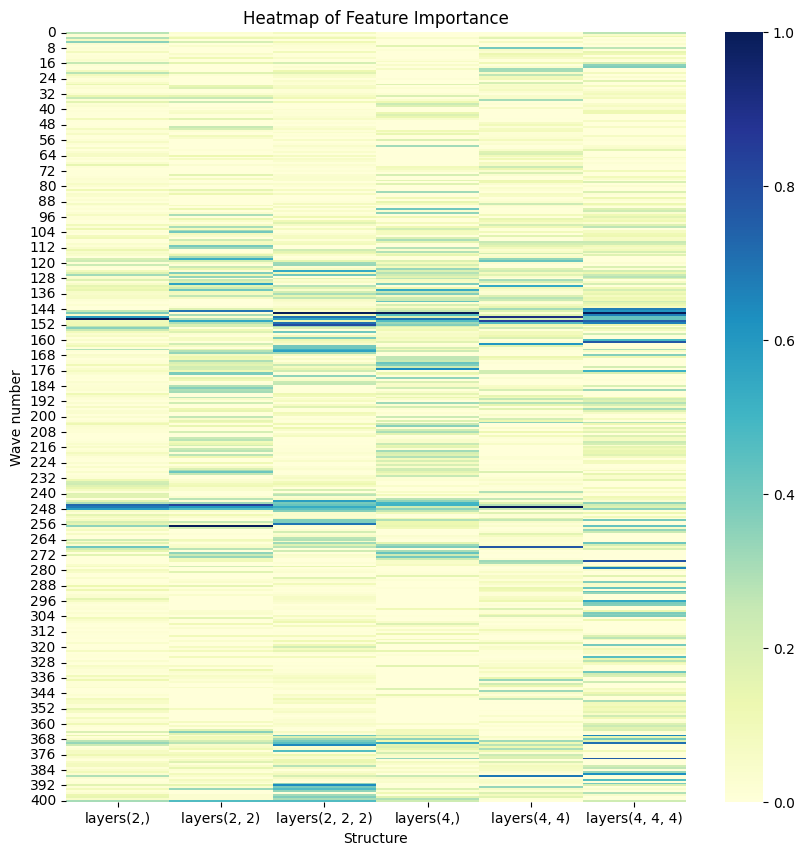

In [10]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_df, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()


### benchmarking

In [19]:
#get some values for different training
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored = pd.DataFrame()

x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

for structure in layers:
    
    for i in np.arange(0,0.4,0.01):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_df.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train[columns_to_keep]
        x_test_important=x_test[columns_to_keep]
        
        #get predictions
        model_nn=MLPRegressor(hidden_layer_sizes=structure,
                            max_iter=10000,
                            random_state=42,)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train.ravel())
        test_pred_important=model_nn.predict(x_test_important)
        test_mse_i = mean_squared_error(y_test, test_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = test_mse_i

In [20]:
stored

,"layers(2,)","layers(2, 2)","layers(2, 2, 2)","layers(4,)","layers(4, 4)","layers(4, 4, 4)"
0.00,0.411073,0.329664,0.106291,0.208900,0.222047,0.462700
0.01,0.169273,0.302308,1.465501,0.152822,0.292696,0.192608
0.02,0.183191,0.815016,0.243604,0.151424,0.233061,0.178310
0.03,0.287455,0.728119,0.353824,0.163607,0.171862,0.140735
0.04,0.325746,0.289616,0.306256,0.274507,0.190370,0.313372
0.05,0.140993,0.270991,0.217777,0.141831,0.255463,0.204897
0.06,0.336379,0.355359,1.464091,0.219748,0.265979,0.353931
0.07,0.414987,0.678773,1.459231,0.249005,0.216840,0.194808
0.08,0.527119,0.264998,0.131398,0.517329,0.183449,0.180690
0.09,0.314138,0.339628,1.459878,0.147525,0.123121,0.227990


In [43]:
#get some values for different training
columns=['threshold','train mse','dev mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)


for i in np.arange(0,0.4,0.01):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_df.T.loc['layers'+str((2,)),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train[columns_to_keep]
    x_dev_important=pd.DataFrame(x_dev)[columns_to_keep]
    x_test_important=x_test[columns_to_keep]
    
    #get predictions
    model_nn=MLPRegressor(hidden_layer_sizes=(2,),
                            max_iter=10000,
                            random_state=42,)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    dev_pred_important=model_nn.predict(x_dev_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train,train_pred_important)
    dev_mse_i=mean_squared_error(y_dev,dev_pred_important)
    test_mse_i = mean_squared_error(y_test, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,dev_mse_i,test_mse_i,num_features]

In [44]:
stored_2

,threshold,train mse,dev mse,test mse,wavelengths included
0.00,0.00,0.253959,0.350079,0.411073,401.0
0.01,0.01,0.085776,0.181413,0.169273,287.0
0.02,0.02,0.075453,0.285623,0.183191,226.0
0.03,0.03,0.111217,0.230468,0.287455,192.0
0.04,0.04,0.178310,0.494788,0.325746,162.0
0.05,0.05,0.081412,0.214926,0.140993,143.0
0.06,0.06,0.190916,0.491499,0.336379,129.0
0.07,0.07,0.243430,0.386756,0.414987,110.0
0.08,0.08,0.265567,0.499063,0.527119,98.0
0.09,0.09,0.142500,0.315252,0.314138,88.0
